<a href="https://colab.research.google.com/github/Fatmamattar/Biological-activity-of-predictor/blob/main/Xgboost_and_Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Mean sample-wise accuracy: 0.11


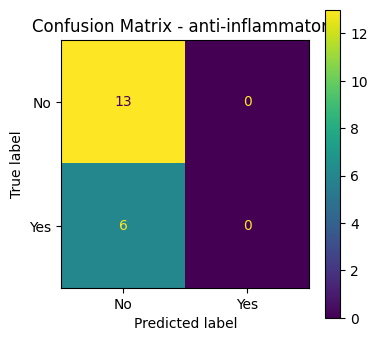

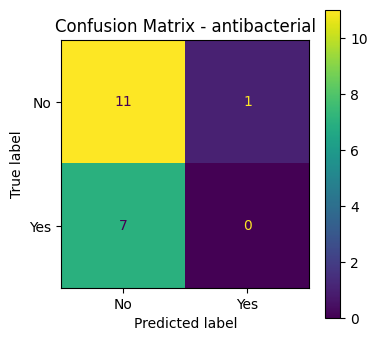

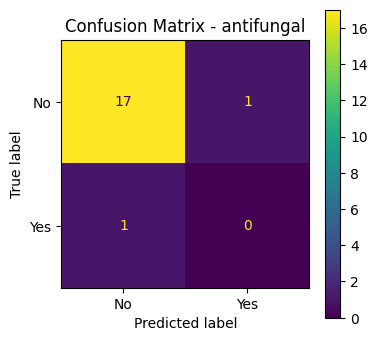

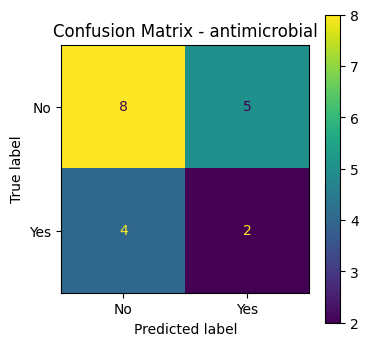

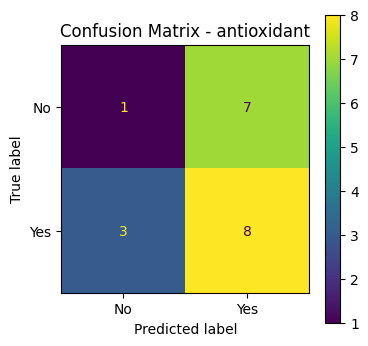

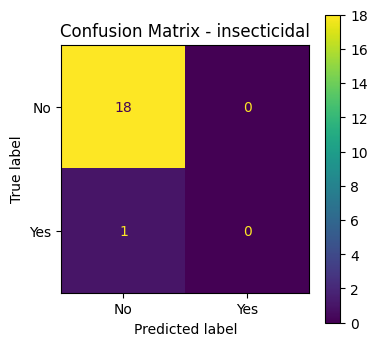

In [ ]:
# Install required libraries (if needed)
!pip install xgboost openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

# Load dataset
df = pd.read_excel("corrected_multilabel_dataset.xlsx", sheet_name="Sheet1")
X = df.drop(columns=["Labels"])
y_raw = df["Labels"].fillna("")

# Process labels
y_split = y_raw.apply(lambda x: [label.strip() for label in x.split(",") if label.strip()])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_split)

# Clean and convert feature names and values
X.columns = (
    X.columns
    .str.replace(r"[\\[\\]<>]", "", regex=True)
    .str.replace(r"[()–—]", "", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "_", regex=True)
    .str.strip()
)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0).to_numpy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = OneVsRestClassifier(
    XGBClassifier(
        use_label_encoder=False,
        objective="binary:logistic",
        eval_metric="logloss",
        learning_rate=0.05,
        max_depth=6,
        n_estimators=300,
        verbosity=0
    )
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Mean sample-wise accuracy: {acc:.2f}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Show confusion matrices per label for current model (XGBoost)
for idx, label in enumerate(mlb.classes_):
    y_true_label = y_test[:, idx]
    y_pred_label = y_pred[:, idx]
    if y_true_label.sum() > 0 or y_pred_label.sum() > 0:
        cm = confusion_matrix(y_true_label, y_pred_label)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
        fig, ax = plt.subplots(figsize=(4, 4))
        disp.plot(ax=ax, values_format='d')
        ax.set_title(f"Confusion Matrix - {label}")
        plt.show()


In [1]:
# Install only if running in Colab
!pip install catboost imbalanced-learn --quiet
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

# Load and clean
df = pd.read_excel("corrected_multilabel_dataset.xlsx", sheet_name="Sheet1")
X = df.drop(columns=["Labels"])
X.columns = X.columns.str.replace(r"[\\[\\]<>]", "", regex=True)

# Labels
y_raw = df["Labels"].fillna("")
y_split = y_raw.apply(lambda x: [label.strip() for label in x.split(",") if label.strip()])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_split)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fake stratification for multilabel: convert multilabels to single string label
y_str = ['|'.join(labels) for labels in y_split]
ros = RandomOverSampler(random_state=42)
X_resampled, y_str_resampled = ros.fit_resample(X_scaled, y_str)

# Convert back to multilabel
y_split_resampled = [label_str.split('|') for label_str in y_str_resampled]
y_resampled = mlb.transform(y_split_resampled)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model
model = MultiOutputClassifier(CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    verbose=0,
    random_seed=42
))
model.fit(X_train, y_train)

from sklearn.metrics import f1_score, classification_report

# Get predicted probabilities
y_prob = model.predict_proba(X_test)
y_prob = np.array([probs[:, 1] for probs in y_prob]).T  # shape: (samples, labels)

# Tune thresholds
best_thresholds = []
for i in range(y_test.shape[1]):
    scores = []
    thresholds = np.arange(0.1, 0.9, 0.05)
    for t in thresholds:
        preds = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test[:, i], preds, zero_division=0)
        scores.append(f1)
    best_threshold = thresholds[np.argmax(scores)]
    best_thresholds.append(best_threshold)

# Apply thresholds
y_pred_thresh = np.zeros_like(y_prob)
for i, t in enumerate(best_thresholds):
    y_pred_thresh[:, i] = (y_prob[:, i] >= t).astype(int)

# Final scores
micro_f1 = f1_score(y_test, y_pred_thresh, average='micro')
macro_f1 = f1_score(y_test, y_pred_thresh, average='macro')

print(f"✅ Tuned Micro F1-score: {micro_f1:.2f}")
print(f"✅ Tuned Macro F1-score: {macro_f1:.2f}")
print(classification_report(y_test, y_pred_thresh, target_names=mlb.classes_))


from sklearn.metrics import accuracy_score
import numpy as np

# Strict accuracy (all labels must match)
strict_accuracy = accuracy_score(y_test, y_pred_thresh)

# Sample-wise accuracy (mean of exact matches per sample)
sample_accuracy = np.mean(np.all(y_pred_thresh == y_test, axis=1))


print(f"Strict Accuracy: {strict_accuracy:.2f}")
print(f"Mean Sample Accuracy: {sample_accuracy:.2f}")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrices for each label
n_labels = y_test.shape[1]
cols = 3
rows = int(np.ceil(n_labels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

for i in range(n_labels):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    cm = confusion_matrix(y_test[:, i], y_pred_thresh[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"Label: {mlb.classes_[i]}")

# Hide empty subplots if any
for j in range(n_labels, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


import gradio as gr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Load data
df = pd.read_excel("corrected_multilabel_dataset.xlsx")
X = df.drop(columns=["Labels"])
y_raw = df["Labels"].fillna("")
y_split = y_raw.apply(lambda x: [label.strip().lower() for label in x.split(",") if label.strip()])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_split)
valid_rows = y.sum(axis=1) > 0
X = X[valid_rows]
y = y[valid_rows]

# Train model
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
model.fit(X, y)

# Use top 10 features for input
input_columns = X.columns[:10]

# Prediction function with confidence
def predict_activities(*args):
    input_data = {col: val for col, val in zip(input_columns, args)}
    for col in X.columns:
        if col not in input_data:
            input_data[col] = 0.0
    df_input = pd.DataFrame([input_data])[X.columns]

    proba = model.predict_proba(df_input)[0]  # Get probability for each label
    label_probs = {label: p for label, p in zip(mlb.classes_, proba)}
    top_labels = [(lbl, round(conf * 100, 2)) for lbl, conf in label_probs.items() if conf > 0.1]
    top_labels.sort(key=lambda x: x[1], reverse=True)

    if not top_labels:
        return "No activity predicted (all confidences < 10%)"

    return "\n".join([f"{label}: {conf}%" for label, conf in top_labels])

# Gradio inputs
inputs = [gr.Slider(0, 10, step=0.1, label=col) for col in input_columns]

# Interface
iface = gr.Interface(fn=predict_activities, inputs=inputs, outputs="text", title="Biological Activity Predictor with Confidence")
iface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: 'corrected_multilabel_dataset.xlsx'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
✅ Tuned Micro F1-score: 0.70
✅ Tuned Macro F1-score: 0.74
                     precision    recall  f1-score   support

  anti-inflammatory       0.40      1.00      0.57        21
      antibacterial       1.00      0.52      0.68        31
         antifungal       0.49      1.00      0.66        31
antifungal activity       1.00      1.00      1.00         7
      antimicrobial       0.63      1.00      0.77        41
        antioxidant       0.60      1.00      0.75        37
          antitumor       1.00      0.94      0.97        17
       insecticidal       0.32      1.00      0.48        15

          micro avg       0.56      0.92      0.70       200
          macro avg       0.68      0.93      0.74       200
       weighted avg       0.66      0.92      0.72       200
        samples avg       0.65      0.93      0.73       200

Strict Accuracy: 0.39
Mean Sample Accuracy: 0.39


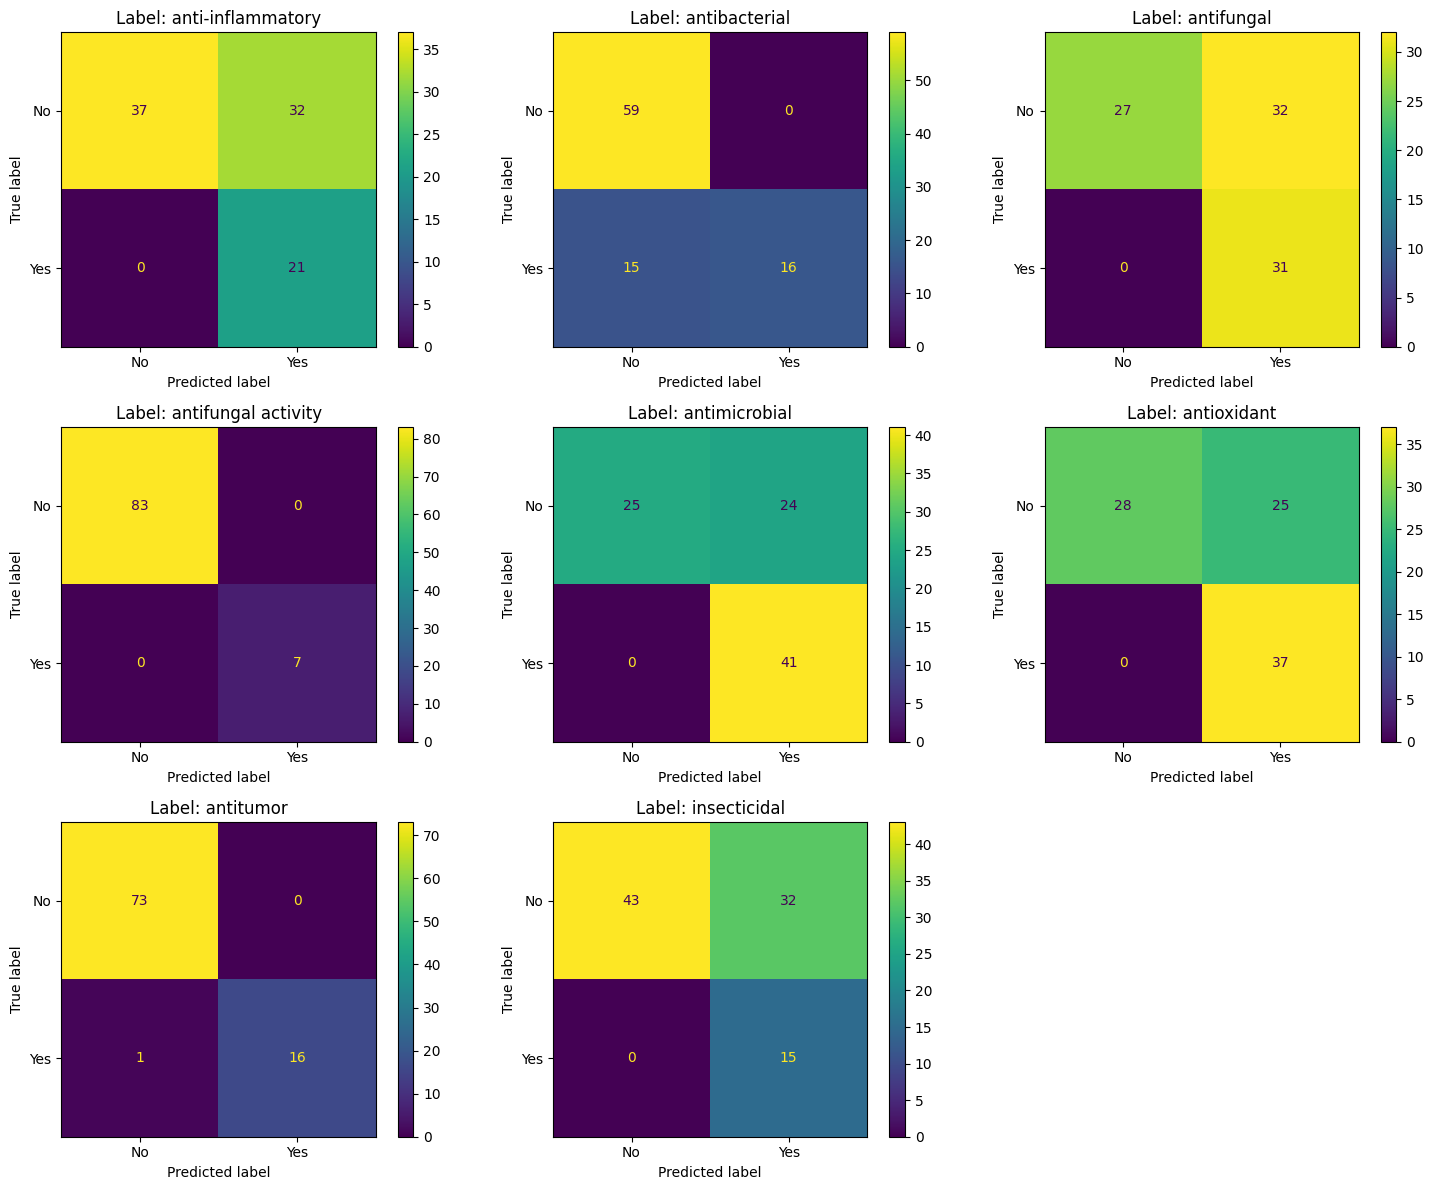

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5f16e6a4de27345839.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Install only if running in Colab
!pip install catboost imbalanced-learn --quiet
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

# Load and clean
df = pd.read_excel("corrected_multilabel_dataset.xlsx", sheet_name="Sheet1")
X = df.drop(columns=["Labels"])
X.columns = X.columns.str.replace(r"[\\[\\]<>]", "", regex=True)

# Labels
y_raw = df["Labels"].fillna("")
y_split = y_raw.apply(lambda x: [label.strip() for label in x.split(",") if label.strip()])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_split)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fake stratification for multilabel: convert multilabels to single string label
y_str = ['|'.join(labels) for labels in y_split]
ros = RandomOverSampler(random_state=42)
X_resampled, y_str_resampled = ros.fit_resample(X_scaled, y_str)

# Convert back to multilabel
y_split_resampled = [label_str.split('|') for label_str in y_str_resampled]
y_resampled = mlb.transform(y_split_resampled)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model
model = MultiOutputClassifier(CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    verbose=0,
    random_seed=42
))
model.fit(X_train, y_train)

from sklearn.metrics import f1_score, classification_report

# Get predicted probabilities
y_prob = model.predict_proba(X_test)
y_prob = np.array([probs[:, 1] for probs in y_prob]).T  # shape: (samples, labels)

# Tune thresholds
best_thresholds = []
for i in range(y_test.shape[1]):
    scores = []
    thresholds = np.arange(0.1, 0.9, 0.05)
    for t in thresholds:
        preds = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test[:, i], preds, zero_division=0)
        scores.append(f1)
    best_threshold = thresholds[np.argmax(scores)]
    best_thresholds.append(best_threshold)

# Apply thresholds
y_pred_thresh = np.zeros_like(y_prob)
for i, t in enumerate(best_thresholds):
    y_pred_thresh[:, i] = (y_prob[:, i] >= t).astype(int)

# Final scores
micro_f1 = f1_score(y_test, y_pred_thresh, average='micro')
macro_f1 = f1_score(y_test, y_pred_thresh, average='macro')

print(f"✅ Tuned Micro F1-score: {micro_f1:.2f}")
print(f"✅ Tuned Macro F1-score: {macro_f1:.2f}")
print(classification_report(y_test, y_pred_thresh, target_names=mlb.classes_))


from sklearn.metrics import accuracy_score
import numpy as np

# Strict accuracy (all labels must match)
strict_accuracy = accuracy_score(y_test, y_pred_thresh)

# Sample-wise accuracy (mean of exact matches per sample)
sample_accuracy = np.mean(np.all(y_pred_thresh == y_test, axis=1))


print(f"Strict Accuracy: {strict_accuracy:.2f}")
print(f"Mean Sample Accuracy: {sample_accuracy:.2f}")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrices for each label
n_labels = y_test.shape[1]
cols = 3
rows = int(np.ceil(n_labels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

for i in range(n_labels):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    cm = confusion_matrix(y_test[:, i], y_pred_thresh[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"Label: {mlb.classes_[i]}")

# Hide empty subplots if any
for j in range(n_labels, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


import gradio as gr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Load data
df = pd.read_excel("corrected_multilabel_dataset.xlsx")
X = df.drop(columns=["Labels"])
y_raw = df["Labels"].fillna("")
y_split = y_raw.apply(lambda x: [label.strip().lower() for label in x.split(",") if label.strip()])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_split)
valid_rows = y.sum(axis=1) > 0
X = X[valid_rows]
y = y[valid_rows]

# Train model
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
model.fit(X, y)

# Use top 10 features for input
input_columns = X.columns[:10]

# Prediction function with confidence
def predict_activities(*args):
    input_data = {col: val for col, val in zip(input_columns, args)}
    for col in X.columns:
        if col not in input_data:
            input_data[col] = 0.0
    df_input = pd.DataFrame([input_data])[X.columns]

    proba = model.predict_proba(df_input)[0]  # Get probability for each label
    label_probs = {label: p for label, p in zip(mlb.classes_, proba)}
    top_labels = [(lbl, round(conf * 100, 2)) for lbl, conf in label_probs.items() if conf > 0.1]
    top_labels.sort(key=lambda x: x[1], reverse=True)

    if not top_labels:
        return "No activity predicted (all confidences < 10%)"

    return "\n".join([f"{label}: {conf}%" for label, conf in top_labels])

# Gradio inputs
inputs = [gr.Slider(0, 10, step=0.1, label=col) for col in input_columns]

import gradio as gr
import gradio as gr

# --- Your predict_activities, input_columns, and model_info must be defined above ---

css = """
body, .gradio-container, .main {
    background: url('https://i.postimg.cc/k5xpH9cC/projectimage.jpg') no-repeat center center fixed !important;
    background-size: cover !important;
}
.gradio-container {
    font-family: 'Segoe UI', 'Roboto', sans-serif;
}
#bio-navbar {
    background: linear-gradient(90deg, #353470 60%, #502a7c 100%);
    padding: 24px 0 10px 0;
    border-radius: 0 0 20px 20px;
    margin-bottom: 0;
    text-align: center;
    box-shadow: 0 3px 26px 2px #190f3b44;
}
#bio-navbar .brand {
    color: #fff;
    font-size: 2.1rem;
    font-weight: bold;
    letter-spacing: 1px;
    margin-right: 32px;
}
#bio-navbar .navlink {
    color: #f1f1f1;
    text-decoration: none;
    margin: 0 18px;
    font-weight: 500;
    font-size: 1.1rem;
    opacity: 0.9;
    transition: color 0.2s;
    border-radius: 8px;
    padding: 7px 18px;
}
#bio-navbar .navlink.active, #bio-navbar .navlink:hover {
    color: #d1aaff;
    background: #4436744a;
}
.biopredictor-hero {
    margin: 0 auto;
    margin-top: 0;
    margin-bottom: 32px;
    max-width: 1100px;
    padding: 48px 0 24px 0;
    text-align: center;
}
.biopredictor-title {
    font-size: 3.3rem;
    font-weight: 800;
    color: #fff;
    letter-spacing: 1.5px;
    line-height: 1;
}
.biopredictor-title .gradient {
    color: #bbaaff;
    font-weight: 900;
}
.biopredictor-subtitle {
    color: #e1d8f7;
    font-size: 1.3rem;
    margin: 28px auto 32px auto;
    max-width: 700px;
    font-weight: 400;
    letter-spacing: 0.5px;
}
.biopredictor-hero .start-btn {
    background: linear-gradient(90deg, #6849e0 60%, #b14fff 100%);
    color: #fff;
    font-size: 1.15rem;
    padding: 16px 46px;
    border: none;
    border-radius: 32px;
    font-weight: bold;
    margin-top: 12px;
    margin-bottom: 36px;
    cursor: pointer;
    transition: background 0.2s, box-shadow 0.2s;
    box-shadow: 0 4px 32px 0 #1a0c3b44;
}
.biopredictor-hero .start-btn:hover {
    background: linear-gradient(90deg, #b14fff 0%, #6849e0 100%);
}
.biopredictor-cards {
    display: flex;
    justify-content: center;
    gap: 28px;
    margin-top: 0;
    margin-bottom: 0;
    flex-wrap: wrap;
}
.biopredictor-feature-card {
    background: rgba(62, 37, 102, 0.96);
    border-radius: 18px;
    padding: 26px 36px 22px 36px;
    flex: 1 1 290px;
    min-width: 280px;
    max-width: 350px;
    box-shadow: 0 2px 24px 2px #190f3b36;
    color: #fff;
    text-align: center;
}
.biopredictor-feature-card .icon {
    font-size: 2.4rem;
    margin-bottom: 12px;
    display: block;
}
.biopredictor-feature-title {
    font-size: 1.27rem;
    font-weight: 700;
    margin-bottom: 8px;
    margin-top: 3px;
}
.biopredictor-feature-desc {
    font-size: 1.08rem;
    color: #e2e0ff;
    font-weight: 400;
}
.biopredictor-about {
    margin: 38px auto 44px auto;
    max-width: 840px;
    border-radius: 18px;
    background: rgba(62, 37, 102, 0.92);
    padding: 40px 40px 32px 40px;
    color: #fff;
    box-shadow: 0 2px 24px 2px #190f3b44;
    text-align: center;
}
.biopredictor-about h2 {
    font-size: 2.1rem;
    font-weight: 800;
    color: #fff;
    margin-bottom: 18px;
    letter-spacing: 1.2px;
}
.biopredictor-about-desc {
    font-size: 1.14rem;
    color: #e1d8f7;
    font-weight: 400;
    margin-bottom: 18px;
    line-height: 1.5;
}
.biopredictor-about-cols {
    display: flex;
    flex-wrap: wrap;
    justify-content: center;
    gap: 40px;
    margin-top: 24px;
}
.biopredictor-about-cols ul {
    text-align: left;
    font-size: 1.06rem;
    color: #fff;
    margin: 0;
    padding-left: 20px;
}
.bio-card {
    background: rgba(38,18,84,0.98);
    max-width: 1020px;
    margin: 0 auto 32px auto;
    border-radius: 18px;
    padding: 28px 36px 28px 36px;
    box-shadow: 0 2px 24px 2px #190f3b44;
    color: #fff;
}
.bio-card h2 {
    color: #ffe083;
    font-size: 1.5rem;
    margin-bottom: 18px;
    text-align: left;
}
.bio-results {
    background: rgba(24, 14, 49, 0.89);
    border-radius: 11px;
    padding: 20px 18px 5px 18px;
    color: #fffde7;
    font-size: 1.17rem;
    margin-bottom: 0;
    box-shadow: 0 0 8px 0 #190f3b22;
    font-weight: 600;
    letter-spacing: 1px;
    min-height: 60px;
}
input[type="range"]::-webkit-slider-thumb {
    background: #b14fff !important;
}
input[type="range"]::-moz-range-thumb {
    background: #b14fff !important;
}
input[type="range"]::-ms-thumb {
    background: #b14fff !important;
}
.bio-section-flex {
    display: flex;
    flex-direction: row;
    gap: 36px;
    margin-top: 20px;
    flex-wrap: wrap;
}
.bio-left, .bio-right {
    flex: 1 1 340px;
    min-width: 320px;
}
.bio-left {
    max-width: 540px;
}
.bio-right {
    max-width: 390px;
    display: flex;
    flex-direction: column;
    gap: 20px;
}
.bio-result-interpretation {
    margin-top: 28px;
    background: rgba(38, 18, 84, 0.97);
    border-radius: 13px;
    padding: 22px 26px 14px 26px;
    box-shadow: 0 0 7px 0 #190f3b26;
}
.bio-result-interpretation h3 {
    font-size: 1.15rem;
    margin-bottom: 10px;
    color: #d5caff;
}
.bio-interpretation-list {
    display: flex;
    flex-wrap: wrap;
    gap: 14px;
}
.bio-interpret-box {
    flex: 1;
    min-width: 180px;
    margin-right: 10px;
    padding: 12px 12px 10px 14px;
    border-radius: 9px;
    background: #2b1a46;
    color: #f1f1f1;
    margin-bottom: 7px;
}
.bio-interpret-box.high { background: #266f4e; color: #e7ffe7; }
.bio-interpret-box.medium { background: #704120; color: #faeacc; }
.bio-interpret-box.low { background: #7c2b2b; color: #ffeaea; }
.bio-interpret-box.verylow { background: #3a2d44; color: #d2c4e7; }
.bio-side-box {
    background: rgba(23, 17, 55, 0.97);
    border-radius: 12px;
    padding: 16px 18px 14px 18px;
    margin-bottom: 0;
    box-shadow: 0 0 7px 0 #190f3b26;
}
.bio-side-box h4 {
    font-size: 1.11rem;
    margin-bottom: 10px;
    color: #f8e7ff;
}
.bio-side-list {
    padding: 0;
    list-style: none;
    margin: 0;
}
.bio-side-list li {
    display: flex;
    justify-content: space-between;
    margin-bottom: 4px;
    font-size: 1rem;
}
.bio-side-list .input-value {
    margin-left: 16px;
    color: #ffe083;
    font-weight: 600;
}
.bio-model-info li {
    font-size: 0.99rem;
}
.bio-important {
    background: rgba(110, 56, 40, 0.92);
    border-radius: 13px;
    padding: 16px 20px 10px 20px;
    margin-bottom: 0;
    margin-top: 8px;
    box-shadow: 0 2px 14px 1px #190f3b22;
    color: #ffefde;
    font-size: 1.06rem;
    font-weight: 500;
}
"""

model_info = {
    "Algorithm": "CatBoost Multi-Output",
    "Version": "1.0.0",
    "Accuracy": "85.2%",
    "F1-Score": "0.84"
}

def styled_predict(*args):
    result = predict_activities(*args)
    if "No activity predicted" in result:
        result_html = f"""<div class="bio-results" style='color:#ffd1d1'>{result}</div>"""
    else:
        lines = result.split("\n")
        colored = []
        for line in lines:
            pct = 0
            try:
                pct = float(line.split(":")[-1].replace("%", "").strip())
            except: pass
            if pct >= 80:
                color = "#42e695"
            elif pct >= 60:
                color = "#ffe083"
            elif pct >= 40:
                color = "#ffb66d"
            else:
                color = "#ff8484"
            colored.append(f"<div style='margin-bottom:6px'><span style='color:{color};font-weight:bold'>{line}</span></div>")
        result_html = "<div class='bio-results'>" + "".join(colored) + "</div>"
    input_html = """
    <div class="bio-side-box">
        <h4>Input Summary</h4>
        <ul class="bio-side-list">
    """
    for col, val in zip(input_columns, args):
        input_html += f'<li><span>{col}:</span><span class="input-value">{val}</span></li>'
    input_html += """
        </ul>
    </div>
    """
    model_html = f"""
    <div class="bio-side-box bio-model-info">
        <h4>Model Information</h4>
        <ul class="bio-side-list">
            <li><b>Algorithm:</b> {model_info['Algorithm']}</li>
            <li><b>Version:</b> {model_info['Version']}</li>
            <li><b>Accuracy:</b> {model_info['Accuracy']}</li>
            <li><b>F1-Score:</b> {model_info['F1-Score']}</li>
        </ul>
    </div>
    """
    important_html = """
    <div class="bio-important">
    ⚠️ <b>Important Notice:</b> These results are computational predictions based on machine learning models.<br>
    While they provide valuable insights, experimental verification through laboratory testing is essential to confirm biological activities before any practical applications or further research decisions.
    </div>
    """
    return result_html, input_html, model_html, important_html

with gr.Blocks(css=css) as iface:
    # NAV BAR (Home only, no Predict or Results)
    gr.HTML("""
    <div id="bio-navbar" style="display:flex;align-items:center;justify-content:space-between;">
        <span class="brand" style="padding-left:36px;">BioPredictor</span>
        <span style="flex:1"></span>
        <span>
            <a class="navlink active" href="#">Home</a>
        </span>
        <span style="width:20px"></span>
    </div>
    """)

    # HERO SECTION
    gr.HTML("""
    <div class="biopredictor-hero">
        <div class="biopredictor-title">
            Biological Activity <span class="gradient">Predictor</span>
        </div>
        <div class="biopredictor-subtitle">
            Advanced machine learning tool powered by CatBoost and multi-label classification to predict biological activities with precision and confidence.
        </div>
        <button class="start-btn" onclick="document.getElementById('biopredictor-inputs').scrollIntoView({behavior: 'smooth'});">
            Start Predicting &nbsp; &rarr;
        </button>
        <div class="biopredictor-cards">
            <div class="biopredictor-feature-card">
                <span class="icon">🟣</span>
                <div class="biopredictor-feature-title">Multi-Label</div>
                <div class="biopredictor-feature-desc">
                    Simultaneous prediction of multiple biological activities with confidence scores
                </div>
            </div>
            <div class="biopredictor-feature-card">
                <span class="icon">📈</span>
                <div class="biopredictor-feature-title">High Accuracy</div>
                <div class="biopredictor-feature-desc">
                    Optimized with threshold tuning and balanced sampling for superior performance
                </div>
            </div>
            <div class="biopredictor-feature-card">
                <span class="icon" style="color:#ffe083;">⚡</span>
                <div class="biopredictor-feature-title">Fast Results</div>
                <div class="biopredictor-feature-desc">
                    Real-time predictions with instant confidence scoring and interpretable results
                </div>
            </div>
        </div>
    </div>
    """)
    # ABOUT SECTION
    gr.HTML("""
    <div class="biopredictor-about">
        <h2>About This Tool</h2>
        <div class="biopredictor-about-desc">
            Our Biological Activity Predictor leverages state-of-the-art machine learning techniques to analyze molecular features and predict potential biological activities. Built with CatBoost gradient boosting and multi-label classification, this tool provides researchers with powerful insights into compound behavior.
        </div>
        <div class="biopredictor-about-cols">
            <div>
                <b>Key Features:</b>
                <ul>
                    <li>• Multi-label biological activity prediction</li>
                    <li>• Confidence scoring for each prediction</li>
                    <li>• Feature importance analysis</li>
                    <li>• Real-time processing</li>
                </ul>
            </div>
            <div>
                <b>Technical Details:</b>
                <ul>
                    <li>• CatBoost gradient boosting algorithm</li>
                    <li>• Threshold optimization for each label</li>
                    <li>• Balanced sampling with RandomOverSampler</li>
                    <li>• F1-score optimization</li>
                </ul>
            </div>
        </div>
    </div>
    """)

    # PREDICTION CARD
    with gr.Column(elem_classes="bio-card", elem_id="biopredictor-inputs"):
        with gr.Row(elem_classes="bio-section-flex"):
            with gr.Column(elem_classes="bio-left"):
                inputs = [gr.Slider(0, 10, step=0.1, label=col) for col in input_columns]
                output = gr.HTML(label="Predicted Activities")
                predict_btn = gr.Button("Predict", elem_id="predict-btn")
            with gr.Column(elem_classes="bio-right"):
                input_summary_html = gr.HTML(label="Input Summary")
                model_info_html = gr.HTML(label="Model Information")
                important_html = gr.HTML(label="Important Notice")
        gr.HTML("""
        <div class="bio-result-interpretation">
            <h3>Result Interpretation</h3>
            <div class="bio-interpretation-list">
                <div class="bio-interpret-box high">
                    <b>High Confidence (≥80%)</b>
                    <span>Strong likelihood of biological activity. Recommended for further investigation.</span>
                </div>
                <div class="bio-interpret-box medium">
                    <b>Medium Confidence (60-79%)</b>
                    <span>Moderate likelihood. Consider additional validation studies.</span>
                </div>
                <div class="bio-interpret-box low">
                    <b>Low Confidence (40-59%)</b>
                    <span>Possible activity detected. Requires experimental confirmation.</span>
                </div>
                <div class="bio-interpret-box verylow">
                    <b>Very Low (&lt;40%)</b>
                    <span>Minimal likelihood of activity. Not typically shown in results.</span>
                </div>
            </div>
        </div>
        """)

    predict_btn.click(
        fn=styled_predict,
        inputs=inputs,
        outputs=[output, input_summary_html, model_info_html, important_html]
    )

iface.launch(share=True)